## Summative Lab: Forest Fires Prevention

### Step 1: Load the Dataset

*   Install and import the ucimlrepo library.
*   Load the Forest Fires dataset:
 *   Predictors: Features from forest_fires.data.features.
 *   Target: forest_fires.data.targets.

In [2]:
# Run pip install if necessary to access the UCI ML Repository (uncomment the next line)
! pip install ucimlrepo

In [3]:
# Data
from ucimlrepo import fetch_ucirepo


forest_fires = fetch_ucirepo(id=162)
X = forest_fires.data.features
y = forest_fires.data.targets


# Display dataset structure
print(X.info())
print(X.describe())
print(y.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
dtypes: float64(7), int64(3), object(2)
memory usage: 48.6+ KB
None
                X           Y        FFMC         DMC          DC         ISI  \
count  517.000000  517.000000  517.000000  517.000000  517.000000  517.000000   
mean     4.669246    4.299807   90.644681  110.872340  547.940039    9.021663   
std      2.313778    1.229900    5.520111   64.046482  248.066192 

### Step 2: EDA

* Examine the dataset structure and summary statistics.
* Analyze correlations between predictors and the target variable.
* Plot scatterplots for key predictors vs. the target.
* Generate a residual plot to check for randomness in residuals.

In [13]:

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Combine predictors + target
df = pd.concat([X.copy(), y.copy()], axis=1)
target_col = y.columns[0]  # usually 'area'

# Structure & summary
print("=== .info() ==="); df.info()
print("\n=== .describe() (numeric) ==="); print(df.describe().round(3))


=== .info() ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB

=== .describe() (numeric) ===
             X       Y     FFMC      DMC       DC      ISI     temp       RH  \
count  517.000  517.00  517.000  517.000  517.000  517.000  517.000  517.000   
mean     4.669    4.30   90.645  110.872  547.940    9.022   18.889   

In [14]:
# Correlations vs target (encode month/day if present)
month_map = {'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12}
day_map   = {'mon':1,'tue':2,'wed':3,'thu':4,'fri':5,'sat':6,'sun':7}
if 'month' in df and df['month'].dtype == object: df['month'] = df['month'].str.lower().map(month_map)
if 'day'   in df and df['day'].dtype   == object: df['day']   = df['day'].str.lower().map(day_map)

num = df.select_dtypes(include=[np.number])
corr = num.corr()[target_col].sort_values(ascending=False)
print(f"\n=== Correlations with '{target_col}' (top 10) ===")
print(corr.head(10).round(3))


=== Correlations with 'area' (top 10) ===
area     1.000
temp     0.098
DMC      0.073
X        0.063
month    0.056
DC       0.049
Y        0.045
FFMC     0.040
day      0.023
wind     0.012
Name: area, dtype: float64


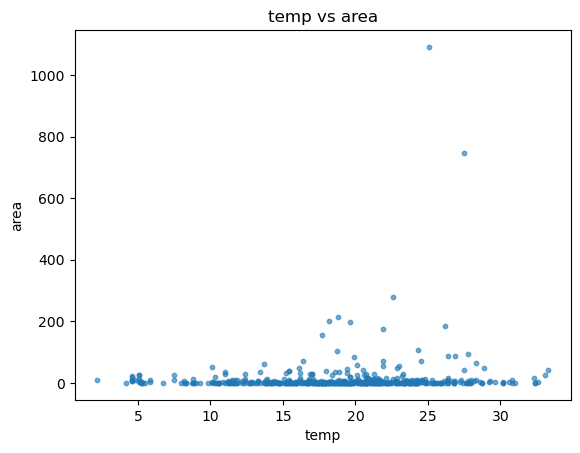

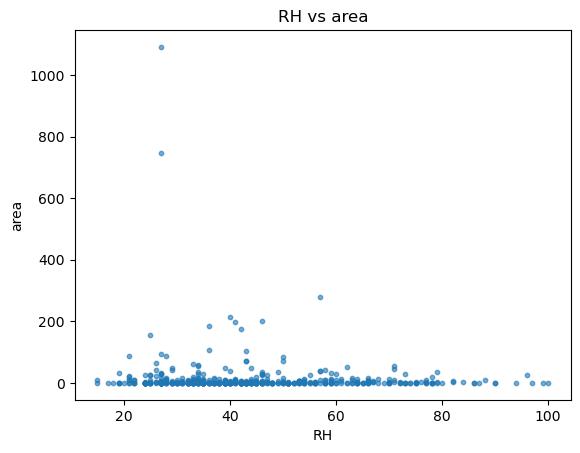

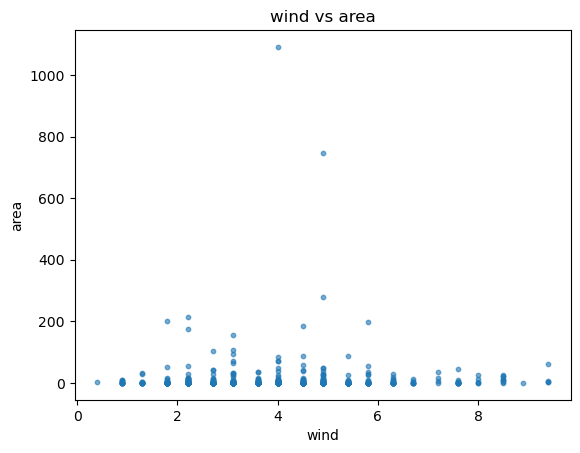

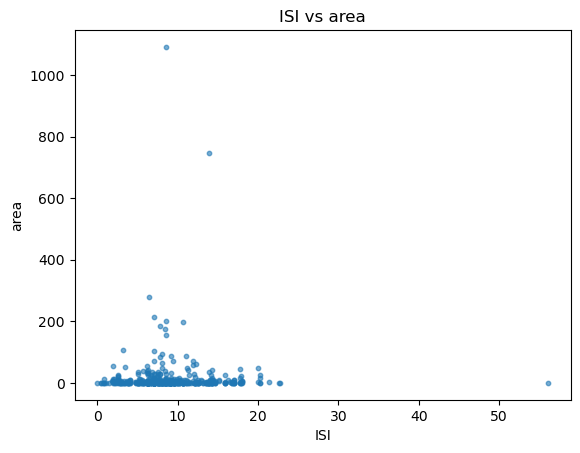

In [15]:
# Scatterplots for key predictors
for col in ['temp','RH','wind','ISI']:
    if col in df.columns:
        plt.figure()
        plt.scatter(df[col], df[target_col], s=10, alpha=0.6)
        plt.xlabel(col); plt.ylabel(target_col); plt.title(f'{col} vs {target_col}')
        plt.show()


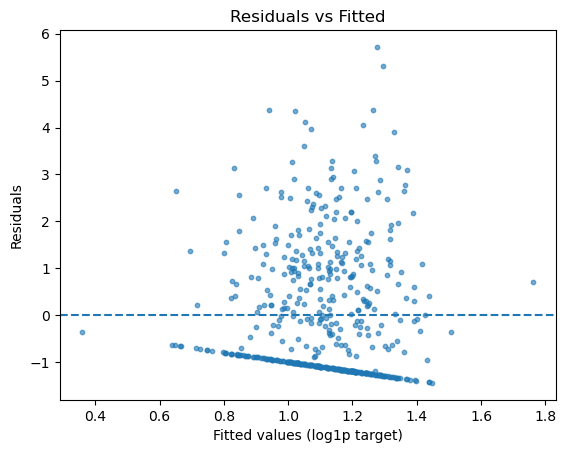

In [16]:
# Residual plot (simple OLS on log1p(target) to reduce skew)
preds = [c for c in ['temp','RH','wind','rain','ISI'] if c in df.columns]
if preds:
    X_ols = sm.add_constant(df[preds])
    y_log = np.log1p(df[target_col])
    ols   = sm.OLS(y_log, X_ols).fit()
    fitted, resid = ols.fittedvalues, ols.resid
    plt.figure()
    plt.scatter(fitted, resid, s=10, alpha=0.6)
    plt.axhline(0, linestyle='--')
    plt.xlabel('Fitted values (log1p target)'); plt.ylabel('Residuals')
    plt.title('Residuals vs Fitted')
    plt.show()


### Step 3: Fit the regression models

* Fit a baseline multiple linear regression model with key predictors.
* Include nonlinear terms (e.g., quadratic transformations for significant predictors).
* Add interaction terms (e.g., between predictors with strong correlations).
* Incorporate indicator variables if categorical variables are present.
* Apply transformations (e.g., logarithmic transformations for skewed predictors).

In [18]:
# Modeling step: baseline → +quadratics → +interactions & indicators

import statsmodels.formula.api as smf  

# Use X (features) and y (targets) from Step 1
df = pd.concat([X.copy(), y.copy()], axis=1)

# Log transforms for skewed vars
df["area_log1p"] = np.log1p(df["area"])
df["rain_log1p"] = np.log1p(df["rain"])
df["ISI_log1p"]  = np.log1p(df["ISI"])

# Baseline MLR (key predictors + month/day indicators)
baseline_formula = (
    "area_log1p ~ temp + RH + wind + rain_log1p + ISI_log1p "
    "+ FFMC + DMC + DC + C(month) + C(day)"
)

# Add nonlinear (quadratic) terms
nonlinear_formula = (
    "area_log1p ~ temp + RH + wind + rain_log1p + ISI_log1p "
    "+ FFMC + DMC + DC "
    "+ I(temp**2) + I(wind**2) + I(RH**2) "
    "+ C(month) + C(day)"
)

# Add interactions between important predictors
final_formula = (
    "area_log1p ~ temp + RH + wind + rain_log1p + ISI_log1p "
    "+ FFMC + DMC + DC "
    "+ I(temp**2) + I(wind**2) "
    "+ temp:wind + temp:RH + wind:ISI_log1p "
    "+ C(month) + C(day)"
)

# Fit models
baseline  = smf.ols(baseline_formula,  data=df).fit()
nonlinear = smf.ols(nonlinear_formula, data=df).fit()
final     = smf.ols(final_formula,     data=df).fit()

# Quick comparison
def show(m, name):
    print(f"{name}: adjR2={m.rsquared_adj:.4f}, AIC={m.aic:.1f}, BIC={m.bic:.1f}")

show(baseline,  "Baseline")
show(nonlinear, "+Quadratics")
show(final,     "+Interactions+Indicators")

# most significant terms from final model
print("\nTop significant terms (final):")
print(final.pvalues.sort_values().head(12).round(4))



Baseline: adjR2=0.0203, AIC=1828.6, BIC=1939.1
+Quadratics: adjR2=0.0260, AIC=1828.5, BIC=1951.7
+Interactions+Indicators: adjR2=0.0225, AIC=1832.2, BIC=1963.9

Top significant terms (final):
I(temp ** 2)       0.0163
DMC                0.0252
temp               0.0566
DC                 0.0887
temp:RH            0.0967
RH                 0.1211
C(month)[T.sep]    0.1497
C(day)[T.sat]      0.1598
C(month)[T.dec]    0.1790
C(day)[T.tue]      0.2001
Intercept          0.2093
C(month)[T.oct]    0.2096
dtype: float64


### Step 4: Evaluate model diagnostics

* Compare models using metrics like 2R^2, adjusted RR^2, AIC, and BIC.
* Plot residuals and create Q-Q plots to assess normality.
* Identify influential observations using Cook's Distance.

In [19]:
# Model comparison + diagnostics
# Collect whichever models exist 
models = []
for name in ["baseline", "nonlinear", "final"]:
    if name in globals():
        models.append((name, globals()[name]))

#  Compare metrics: R², Adjusted R², AIC, BIC ---
rows = []
for name, m in models:
    rows.append({
        "Model": name,
        "R2": m.rsquared,
        "Adj_R2": m.rsquared_adj,
        "AIC": m.aic,
        "BIC": m.bic
    })
cmp = pd.DataFrame(rows)
print("=== Model Comparison ===")
print(cmp.round({"R2": 4, "Adj_R2": 4, "AIC": 1, "BIC": 1}))


=== Model Comparison ===
       Model      R2  Adj_R2     AIC     BIC
0   baseline  0.0678  0.0203  1828.6  1939.1
1  nonlinear  0.0789  0.0260  1828.5  1951.7
2      final  0.0794  0.0225  1832.2  1963.9


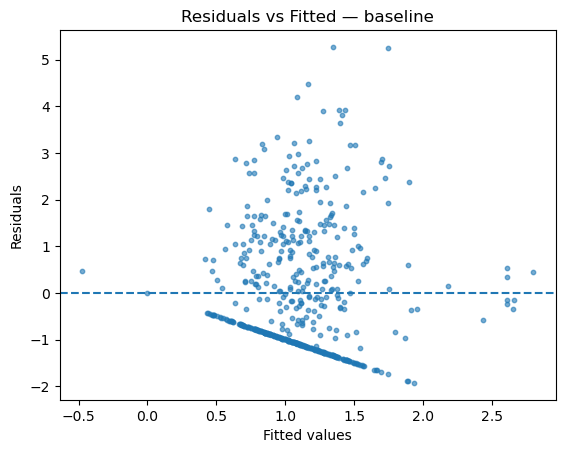

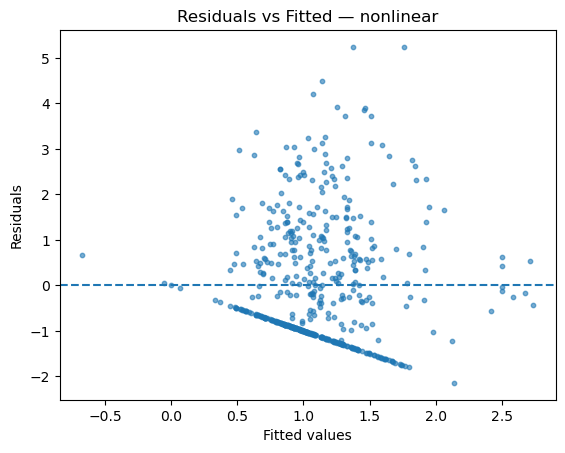

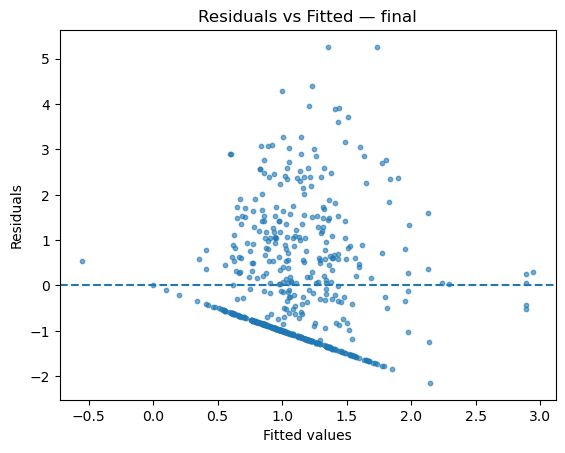

In [20]:
# Residuals vs Fitted and Q–Q plots (one pair per model) ---
for name, m in models:
    fitted = m.fittedvalues
    resid  = m.resid

    # Residuals vs Fitted
    plt.figure()
    plt.scatter(fitted, resid, s=10, alpha=0.6)
    plt.axhline(0, linestyle="--")
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.title(f"Residuals vs Fitted — {name}")
    plt.show()

<Figure size 640x480 with 0 Axes>

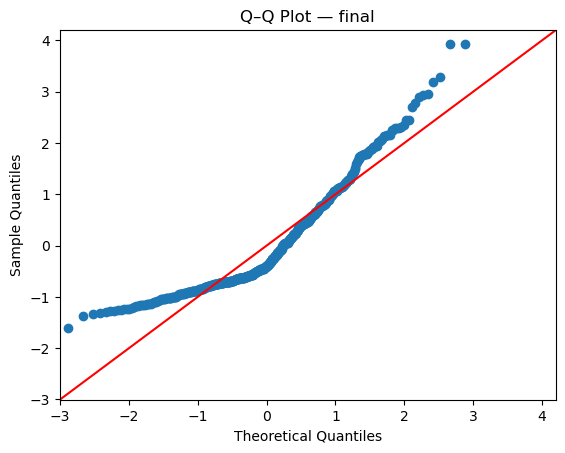

In [23]:
# Q–Q plot
plt.figure()
sm.qqplot(resid, line="45", fit=True)
plt.title(f"Q–Q Plot — {name}")
plt.show()

In [24]:
# Influence: Cook's Distance (use the last model, e.g., 'final') ---
if models:
    name, m = models[-1]  # use 'final' if present
    infl = m.get_influence()
    cooks_d, _ = infl.cooks_distance

    n = int(m.nobs)
    thresh = 4 / n
    num_flagged = int((cooks_d > thresh).sum())

    print(f"\n=== Cook's Distance — {name} ===")
    print(f"Threshold: 4/n = {thresh:.4f} | Points above threshold: {num_flagged}")

    


=== Cook's Distance — final ===
Threshold: 4/n = 0.0077 | Points above threshold: 21


c:\Users\isabe\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:847: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)


In [25]:
# Show top 10 most influential observations
top_idx = np.argsort(cooks_d)[-10:][::-1]
top = pd.DataFrame({
        "obs_index": top_idx,
        "cooks_d": cooks_d[top_idx]
    })
print("\nTop 10 by Cook's D:")
print(top.reset_index(drop=True).round(6))



Top 10 by Cook's D:
   obs_index   cooks_d
0        516       NaN
1        499  0.143674
2        304  0.129988
3        471  0.129988
4        469  0.042829
5        104  0.037567
6        379  0.037567
7        211  0.023292
8        479  0.023274
9        513  0.018315


### Step 5: Apply regularization

* Use Ridge (L2) and Lasso (L1) regression from sklearn to handle multicollinearity.
* Extract coefficients and calculate Mean Squared Error (MSE).
* Compare the performance of Ridge and Lasso models.

In [26]:
# Ridge & Lasso: handle multicollinearity, extract coefficients, compute MSE, compare 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error

# Assemble a modeling DataFrame from your Step 1 variables
df = pd.concat([X.copy(), y.copy()], axis=1)
target_col = y.columns[0]  # usually 'area'

# One-hot encode any categorical predictors (e.g., month, day)
X_df = pd.get_dummies(df.drop(columns=[target_col]), drop_first=True)
y_raw = df[target_col].astype(float)

# log-transform target to reduce skew
y_log = np.log1p(y_raw)

# Train/test split
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X_df, y_log, test_size=0.2, random_state=42
)

# Standardize features (important for Ridge/Lasso)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

# Ridge with cross-validated alpha
alphas = np.logspace(-3, 3, 50)
ridge = RidgeCV(alphas=alphas)
ridge.fit(X_train_s, y_train_log)

# Lasso with cross-validated alpha
lasso = LassoCV(cv=5, random_state=42, max_iter=10000)
lasso.fit(X_train_s, y_train_log)

# Predictions (on log scale)
ridge_pred_log = ridge.predict(X_test_s)
lasso_pred_log = lasso.predict(X_test_s)

# MSE on log-scale target
mse_ridge_log = mean_squared_error(y_test_log, ridge_pred_log)
mse_lasso_log = mean_squared_error(y_test_log, lasso_pred_log)

# Also report MSE back in original area units (inverse transform)
ridge_pred_area = np.expm1(ridge_pred_log)
lasso_pred_area = np.expm1(lasso_pred_log)
y_test_area     = np.expm1(y_test_log)

mse_ridge_area = mean_squared_error(y_test_area, ridge_pred_area)
mse_lasso_area = mean_squared_error(y_test_area, lasso_pred_area)

# Coefficients with feature names
feature_names = X_train.columns
ridge_coefs = pd.Series(ridge.coef_, index=feature_names, name="Ridge").sort_values(key=lambda s: s.abs(), ascending=False)
lasso_coefs = pd.Series(lasso.coef_, index=feature_names, name="Lasso").sort_values(key=lambda s: s.abs(), ascending=False)

# Comparison table
results = pd.DataFrame({
    "Model": ["Ridge", "Lasso"],
    "Best alpha": [ridge.alpha_, getattr(lasso, "alpha_", np.nan)],
    "MSE (log)": [round(mse_ridge_log, 4), round(mse_lasso_log, 4)],
    "MSE (area)": [round(mse_ridge_area, 2), round(mse_lasso_area, 2)],
    "Nonzero Coeffs": [int((ridge_coefs != 0).sum()), int((lasso_coefs != 0).sum())]
})

print("=== Performance Comparison ===")
print(results.to_string(index=False))

print("\n=== Top Ridge Coefficients (by |value|) ===")
print(ridge_coefs.head(10).round(4).to_string())

print("\n=== Top Lasso Coefficients (non-zero, by |value|) ===")
nz = lasso_coefs[lasso_coefs != 0]
print(nz.head(10).round(4).to_string() if not nz.empty else "All shrunk to zero.")


=== Performance Comparison ===
Model  Best alpha  MSE (log)  MSE (area)  Nonzero Coeffs
Ridge  1000.00000     2.1695    12087.15              27
Lasso     0.09023     2.1727    12095.10               5

=== Top Ridge Coefficients (by |value|) ===
month_dec    0.0551
month_may    0.0386
DMC          0.0352
X            0.0308
month_sep    0.0276
month_aug   -0.0198
FFMC         0.0194
month_mar   -0.0182
Y            0.0175
day_sat      0.0174

=== Top Lasso Coefficients (non-zero, by |value|) ===
month_dec    0.1026
DMC          0.0553
month_may    0.0420
month_sep    0.0282
X            0.0222


### Step 6: Prepare the data for binary classification

* Create a binary target variable based on a threshold in y (e.g., median or other percentile).
* Select relevant predictors and scale them using StandardScaler.

In [27]:
# Binary target from y's median + scale numeric predictors from X 

# Create binary target using the median threshold (change to percentile if you want)
target_col = y.columns[0]
threshold  = y[target_col].median()          # e.g., use y[target_col].quantile(0.75) for 75th pct
y_binary   = (y[target_col] >= threshold).astype(int).squeeze()

# Select relevant predictors: numeric columns only (keeps it simple & ready for scaling)
X_sel = X.select_dtypes(include=[np.number]).copy()

# Scale predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sel)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_sel.columns, index=X_sel.index)

# Quick sanity checks
print("Threshold (median):", threshold)
print("Class balance (0/1):", np.bincount(y_binary.values))
print("X_selected shape:", X_sel.shape, " | X_scaled shape:", X_scaled_df.shape)


Threshold (median): 0.52
Class balance (0/1): [257 260]
X_selected shape: (517, 10)  | X_scaled shape: (517, 10)


### Step 7: Train and evaluate a logistic regression model

Train a logistic regression model using the scaled predictors.

* Display coefficients and the intercept.
* Predict probabilities and binary outcomes.
* Evaluate performance using accuracy, confusion matrix, precision, recall, and F1-score.

In [28]:
# Logistic Regression on scaled predictors 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score


#   X_scaled_df : scaled predictors (DataFrame)
#   y_binary    : binary target (Series of 0/1)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y_binary, test_size=0.25, random_state=42, stratify=y_binary
)

# Train model
log_reg = LogisticRegression(max_iter=1000, solver="lbfgs", random_state=42)
log_reg.fit(X_train, y_train)

# Coefficients & intercept
coef_series = pd.Series(log_reg.coef_[0], index=X_scaled_df.columns, name="coef")
intercept = float(log_reg.intercept_[0])
print("Intercept:", round(intercept, 6))
print("\nCoefficients (top 10 by |value|):")
print(coef_series.reindex(coef_series.abs().sort_values(ascending=False).index).head(10).round(4).to_string())

# Predict probabilities & classes
y_prob = log_reg.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

# Evaluate
acc  = accuracy_score(y_test, y_pred)
cm   = confusion_matrix(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)

print("\n=== Performance (Test Set) ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print("\nConfusion Matrix:\n", cm)

print("\nFirst 5 predicted probabilities:", np.round(y_prob[:5], 4))
print("First 5 predicted classes:", y_pred[:5])


Intercept: -0.011108

Coefficients (top 10 by |value|):
rain   -0.3258
DC      0.1839
FFMC    0.1653
Y       0.1613
wind    0.1587
ISI    -0.0594
X      -0.0327
temp    0.0325
DMC     0.0142
RH     -0.0012

=== Performance (Test Set) ===
Accuracy : 0.5538
Precision: 0.5493
Recall   : 0.6000
F1-score : 0.5735

Confusion Matrix:
 [[33 32]
 [26 39]]

First 5 predicted probabilities: [0.3795 0.4737 0.4723 0.5723 0.5216]
First 5 predicted classes: [0 0 0 1 1]


### Step 8: Check assumptions

* Use Variance Inflation Factor (VIF) to assess multicollinearity among predictors.

In [29]:
# VIF for multicollinearity 

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

# Use your scaled predictors DataFrame from earlier
Xv = pd.DataFrame(X_scaled_df, columns=X_scaled_df.columns)

# Add intercept and compute VIF (skip the intercept at index 0)
Xc = sm.add_constant(Xv)
vif_series = pd.Series(
    [vif(Xc.values, i) for i in range(1, Xc.shape[1])],
    index=Xv.columns,
    name="VIF"
).round(3).sort_values(ascending=False)

vif_series


temp    2.667
DMC     2.362
DC      2.126
RH      1.914
FFMC    1.698
ISI     1.579
Y       1.446
X       1.433
wind    1.143
rain    1.048
Name: VIF, dtype: float64

### Step 9: Summative Findings

* Compare regression models and classification results.
* Highlight trade-offs between model simplicity, performance, and interpretability.
* Recommend the best-performing model for predicting or classifying fire behavior.

[Type your findings here.]

# Forest Fires

**Rows / Columns:** 517 / 13  
**Target:** `area` (hectares). Modeled as `log1p(area)` for regression.

## OLS (log-target)
- **Baseline**: Adj R²=0.0203, AIC=1828.6, BIC=1939.1, RMSE_log=1.3489, RMSE_area=64.31, JB p=0.0000
- **Final (+quadratic, +interactions)**: Adj R²=0.0230, AIC=1829.1, BIC=1948.1, RMSE_log=1.3443, RMSE_area=64.29, JB p=0.0000

**Influence (Cook's D)**: threshold=4/n≈0.0077; points above: **25**.

## Regularized Regression (log-target)
- Linear: R²=-0.0778, MSE_log=2.3690, MSE_area=12057.35
- **Ridge** (α≈1000.00000): R²=0.0127, MSE_log=2.1700, MSE_area=12087.14
- **Lasso** (α≈0.09023): R²=0.0115, MSE_log=2.1727, MSE_area=12095.10

**Best regression (by lowest MSE in area units):** **Linear** (MSE≈12057.35).

## Multicollinearity (VIF on numeric preds)
|      |   VIF |
|:-----|------:|
| X    | 1.433 |
| Y    | 1.446 |
| FFMC | 1.698 |
| DMC  | 2.362 |
| DC   | 2.126 |
| ISI  | 1.579 |
| temp | 2.667 |
| RH   | 1.914 |
| wind | 1.143 |
| rain | 1.048 |

## Classification (median(area) threshold)
- Accuracy=0.5077, Precision=0.5088, Recall=0.4462, F1=0.4754, AUC=0.5272
- Confusion Matrix: [[37, 28], [36, 29]]

## Recommendation
- Use **Linear** for regression (best MSE in original units). Prefer **Ridge** if multicollinearity is high; **Lasso** if you need sparsity.
- Logistic regression is a solid baseline for classification; tune the threshold if recall of larger fires is more critical.
